# Introduction

The goal of this notebook is to exemplify community detection with hierarchical stochastic block models (hSBM) with the `tidygraphtool` api.

In [1]:
import os, sys

import pyarrow.feather as feather
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graph_tool.all as gt

PROJ_DIR = os.pardir

# Import custom package
src_dir = os.path.join(f"{PROJ_DIR}")
sys.path.append(src_dir)

from tidygraphtool.all import *

In [4]:
#edges = edges.query("Source.isin(@nodes.id) & Target.isin(@nodes.id)")

## Build Graph

As in the `tidygraph` package in `R`, we represent a graph as two tidy dataframes. To build a graph, we provide a nodes and edges dataframe to the function `gt_graph`. Following `networkx` convention, `gt_graph` will look for a `source` and `target` columns in the edges dataframe. For the nodes dataframe, `gt_graph` needs a matching column that corresponds to edge terminals. By default, `gt_graph` will look for a `name` column, but a different value can be passed to the `node_key` argument, as shown below. If neither are present, `gt_graph` will assume that the first col is the matching column.

In [25]:
g = gt_graph(nodes = nodes, edges = edges, directed = True, node_key = "id")

Note that sometimes we only have the interactions. If this is the case, then either of the follower would work:
```
gt_graph(edges=edges)
as_gt_graph(edges=edges)
```
Similar to the philosophy of `tidygraph` works, the function `as_gt_graph` aims to work with really anything you can throw at it. For now, this only means `DataFrame`, `networkx` object, and `igraph` object. Now that we have our graph, we can inspect it with `summary`:

In [6]:
summary(g)

                       id      screen_name  followers   type  start.phi
0     1000274858247446528    Margotte57000       6575  users        999
1     1002862617734668288      XavierGateL       2870  users        999
2     1002898007300427776  lesamisdelabbe1        637  users        999
3               100452627    ArthurLABARRE       1138  users        999
4               100496102      GetchTchern        767  users        999
...                   ...              ...        ...    ...        ...
2214            294655305  PhilippeMichelK       4265  elite          0
2215             38162566     yannwehrling       3655  elite          0
2216            636832999  beaudetstephane       2310  elite          1
2217             23339701   sandrinebelier      10193  elite         -1
2218            505998825         jp_gille       4488  elite         -1

[2219 rows x 5 columns]
       source  target  n
0           0    1817  1
1           0    1818  1
2           0    1819  1
3          

We see that `g` contains not only the main information, but also the metadata for each dataframe.

## Network wrangling

Now that we have a graph, we want to manipulate it to better understand it. For the moment, we can interact with the libraries with or without `piping`. Pipes (`>>`) can be read as _then_, by that we mean that the following snippet would be to first take `g`, _then_ add property coreness, _then_ filter on coreness greater than 3:

In [7]:
g = g >> add_property("degree_in", centrality_degree(g, mode="in"))

In [8]:
# If more than one line
u = (
  g >> 
    add_property("degree_in", centrality_degree(g, mode="in")) >>
    filter_on("degree_in >= 20")
)

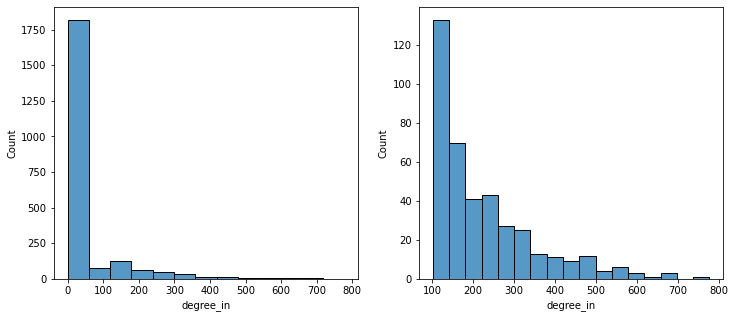

In [9]:
# we cast g as dataframe by the function of the same name
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
sns.histplot(as_data_frame(g).degree_in, ax=ax1)
sns.histplot(as_data_frame(u).degree_in, ax=ax2);

In [26]:
activate(g, "edges")

<Graph object, directed, with 2219 vertices and 90345 edges, 5 internal vertex properties, 1 internal edge property, 1 internal graph property, at 0x7faf59c9f550>

In [42]:
u = (
   g >>
     activate("nodes") >>
     add_property("node_coreness", node_coreness(g)) >>
     filter_on("node_coreness >= 30") >>
     activate("edges") >>
     filter_on("source == 0") 
)

In [43]:
summary(u)

    source  target  n
0        0    1034  1
1        0    1035  1
2        0    1036  1
3        0    1037  1
4        0    1038  1
..     ...     ... ..
56       0    1090  1
57       0    1091  1
58       0    1092  1
59       0    1093  1
60       0    1094  1

[61 rows x 3 columns]
                       id      screen_name  followers   type  start.phi  \
0     1000274858247446528    Margotte57000       6575  users        999   
1     1002862617734668288      XavierGateL       2870  users        999   
2     1002898007300427776  lesamisdelabbe1        637  users        999   
3               100452627    ArthurLABARRE       1138  users        999   
4     1006995694153093120   Philippine9277       1578  users        999   
...                   ...              ...        ...    ...        ...   
1431            294655305  PhilippeMichelK       4265  elite          0   
1432             38162566     yannwehrling       3655  elite          0   
1433            636832999  beaudetstep

In [29]:
state = gt.minimize_nested_blockmodel_dl(g, deg_corr=True)

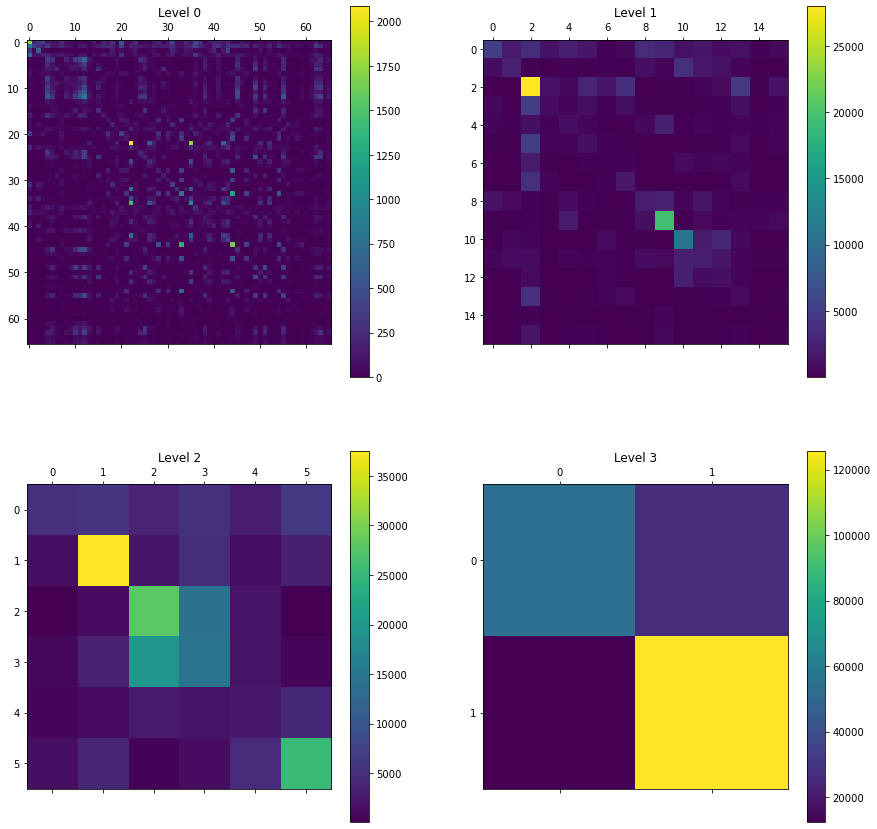

In [35]:
plot_trypic_blocks(state)

In [32]:
block_mat, block_mat2 = make_mat_size(state, lvl=0)

In [36]:
group_df = unnest_state(state)
group_df["id"] = group_df.index